In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy import fftpack
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ARIMA
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings("ignore")

sns.set_theme(context="paper", style="whitegrid", palette="tab10", font="Century Gothic")
plt.rcParams["figure.figsize"] = (16,6)

In [2]:
# load data

data = pd.read_csv("./data/train_IxoE5JN.csv", parse_dates=["datetime"]).set_index("datetime")["energy"]
data.head()

datetime
2008-03-01 00:00:00    1259.985563
2008-03-01 01:00:00    1095.541500
2008-03-01 02:00:00    1056.247500
2008-03-01 03:00:00    1034.742000
2008-03-01 04:00:00    1026.334500
Name: energy, dtype: float64

In [3]:
# data statistics

print(data.info())
print(data.describe())

<class 'pandas.core.series.Series'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Series name: energy
Non-Null Count  Dtype  
--------------  -----  
93092 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB
None
count    93092.000000
mean      1702.995014
std        369.322103
min        866.388600
25%       1431.541100
50%       1654.465800
75%       1935.993450
max       3374.399600
Name: energy, dtype: float64


There are a few null values. We shall do a forward fill to remove the null values.

In [4]:
data.fillna(method="ffill", inplace=True)

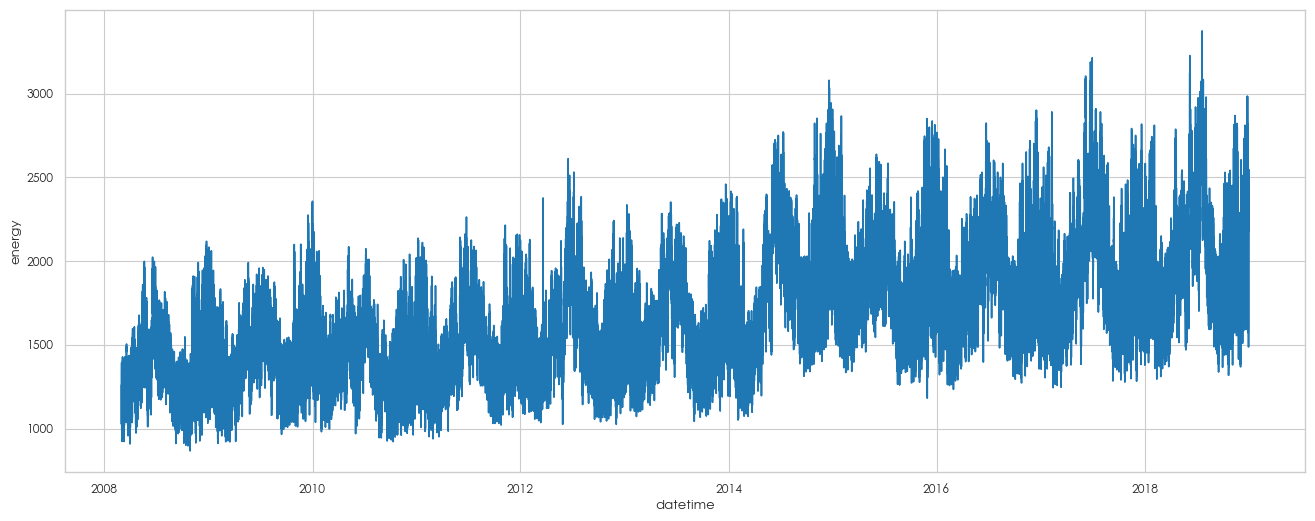

In [5]:
# time-series plot

sns.lineplot(data);

From the plot, we can clearly see a slight trend. Heavy seasonality exists throughout, which we will capture to train the model.

Now, let's plot the various frequencies of the series.

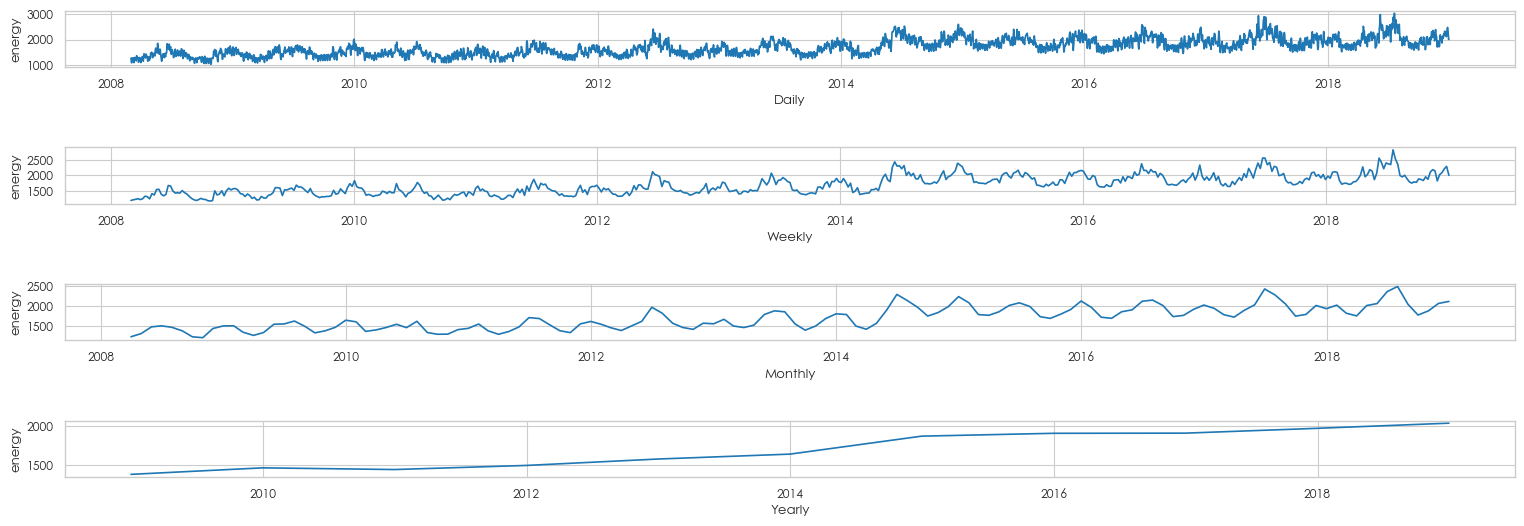

In [6]:
# plotting various frequencies

frequencies = {"D": "Daily", "W": "Weekly", "M": "Monthly", "Y": "Yearly"}

fig, ax = plt.subplots(nrows=len(frequencies), ncols=1)
fig.tight_layout(pad=4.0)

for idx, freq in enumerate(frequencies):
    sns.lineplot(data.resample(freq).mean(), ax=ax[idx])
    ax[idx].set_xlabel(f"{frequencies[freq]}")

The cyclical behavior exists each day, each month and each year. This can be best captured using a `Fast-Forier-Transform`.

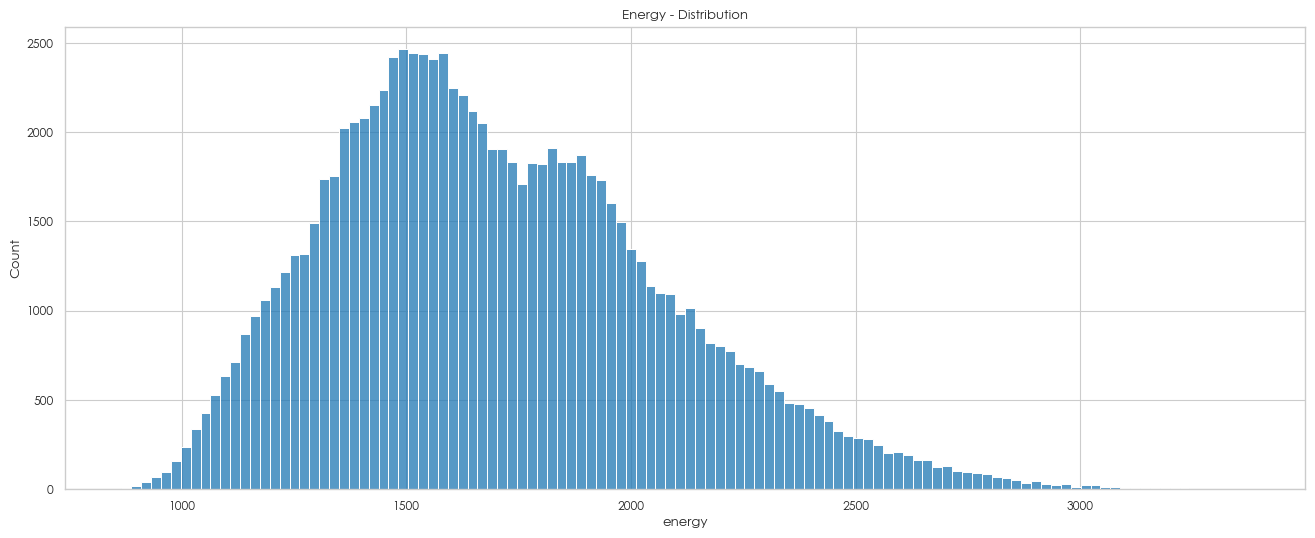

In [7]:
# histplot

sns.histplot(data)
plt.title("Energy - Distribution");

The data is clearly skewed to the right. We shall do a log-transformation to check if the distribution becomes normal.

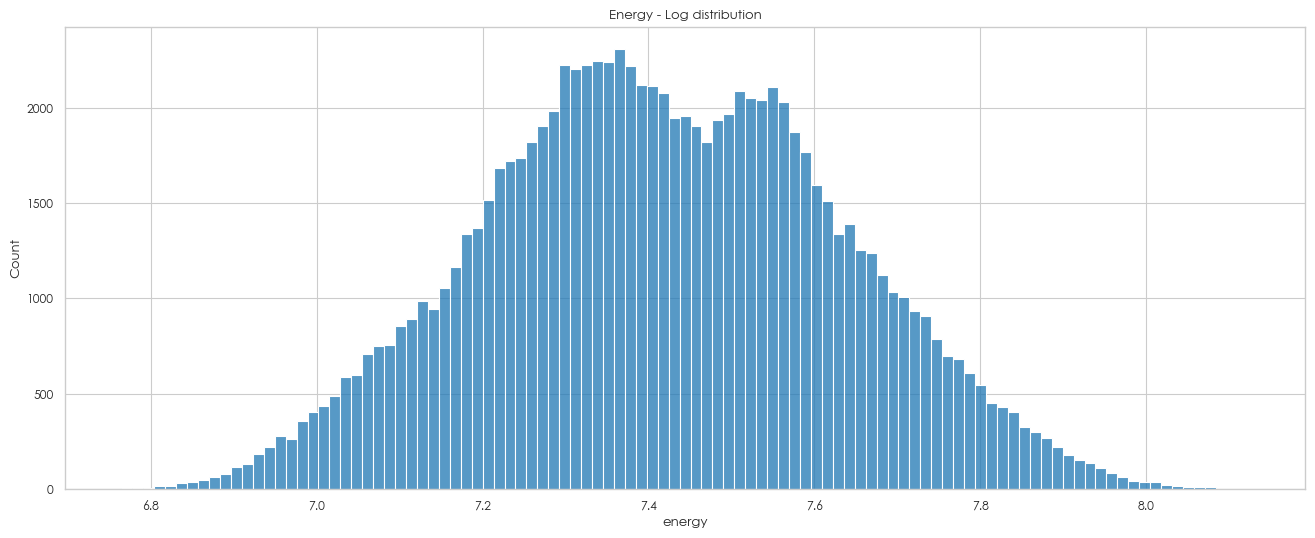

In [8]:
# histplot on log of series

sns.histplot(data.apply(np.log))
plt.title("Energy - Log distribution");

Visually, the distribution looks more normal after the log-transformation.

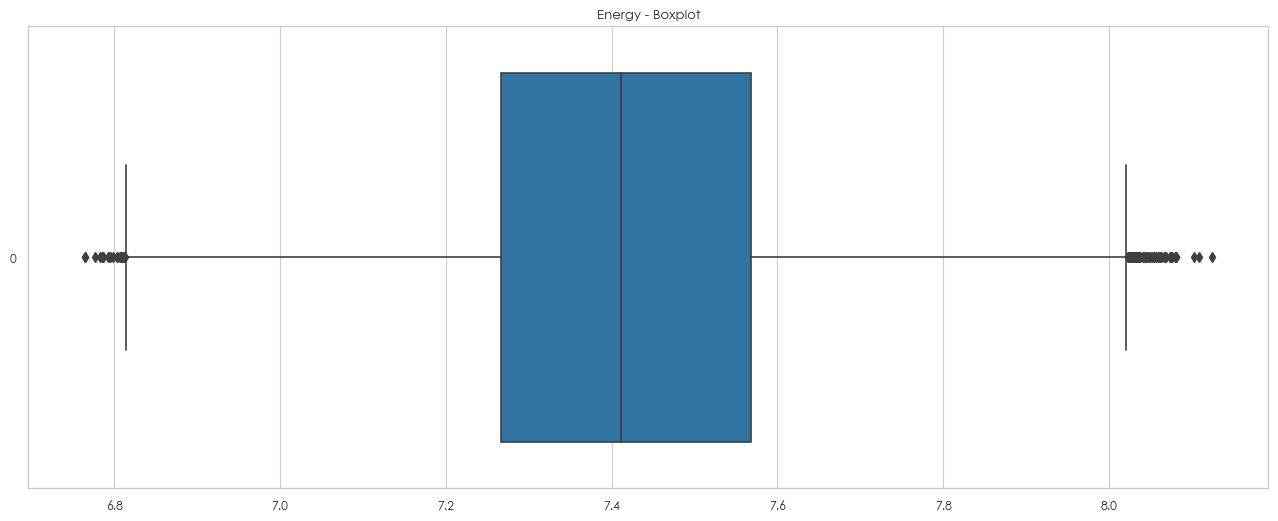

In [9]:
# box-plot

sns.boxplot(data.apply(np.log), orient="h")
plt.title("Energy - Boxplot");

There are no huge shocks in the series. We will not process any outliers in the data.

Let's plot the fourier component to check the dominant frequencies

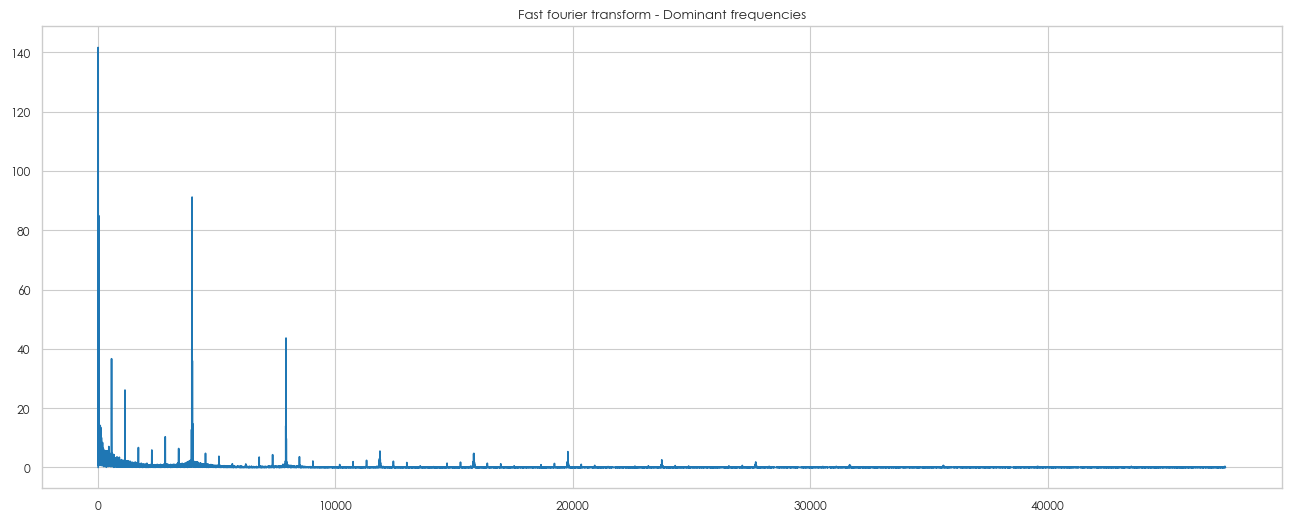

In [10]:
fft = fftpack.fft(data.values - data.values.mean())
f = np.linspace(0, len(fft), len(fft))

sns.lineplot(x=f[:len(fft)//2], y=np.abs(fft[:len(fft)//2])/len(fft))
plt.title("Fast fourier transform - Dominant frequencies");

The most dominant frequency occurs daily, yearly and twice a year.

Now that we have idea about the distribution, let's build the model to predict the future energy demand.

### Strategy:

* Use linear regression and fast fourier transform to capture the trend and seasonality.
* Inspect ACF and PACF plot to check correlation on the residual.
* Use classical time-series model for modelling the residual.

We shall define few custom transformer class that will help in the model workflow.

In [11]:
# Index transformer

class DateTransformer(BaseEstimator, TransformerMixin):
    '''
    Transformer to generate features from the datetime
    
    Parameters
    ----------
    return_features: bool
        if true, returns the hour, day, week, month and year
        if false, returns decimal of the date with a bias added based on the daily cycle
    '''
    def __init__(self, return_features=False):
        self.return_features = return_features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        dt = pd.Series(X)
        
        if not self.return_features:
            
            def time_bias(x):
                if x.hour in np.arange(1, 7):
                    return 0
                elif x.hour in np.arange(7, 12):
                    return 0.75
                elif x.hour in np.arange(12,19):
                    return 0.5
                else:
                    return 0.25
                
            decimal_date = dt.apply(lambda x: x.year + (x.dayofyear - 1)/365) + dt.apply(time_bias)
            return np.array(decimal_date).reshape(-1, 1)
        
        else:
            return np.vstack([
                [dt.apply(lambda x: x.hour)], 
                [dt.apply(lambda x: x.day)], 
                [dt.apply(lambda x: x.week)], 
                [dt.apply(lambda x: x.month)], 
                [dt.apply(lambda x: x.year)]]).T

In [12]:
# Fourier transformer

class FourierTransformer(BaseEstimator, TransformerMixin):
    '''
    Create features based on sin(2*pi*f*t) and cos(2*pi*f*t)
    
    parameters
    ----------
    freqs: List of frequencies

    '''
    def __init__(self, freqs):
        self.freqs = freqs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = np.zeros((X.shape[0], 2*len(self.freqs)))
        for i, f in enumerate(self.freqs):

            Xt[:, 2*i]= np.cos(2*np.pi*f*np.array(X)).reshape(-1)
            Xt[:, 2*i + 1] = np.sin(2*np.pi*f*np.array(X)).reshape(-1)
    
        return Xt

#### Train test split

In [13]:
# split data into train and test set (label -> log(energy))

X_train, X_test, y_train, y_test = train_test_split(data.index, np.log(data.values), test_size=0.2, shuffle=False)

#### Baseline model that captures trend and seasonality

In [14]:
freqs = np.hstack([np.arange(1,5), np.arange(330,390), np.arange(690,770)]) # based on few trial and error by adjusting the amount of daily, monthly and yearly components


#create ml-pipeline

union = FeatureUnion(
    [
        ("polynomial", PolynomialFeatures(1)),
        ("fourier", FourierTransformer(freqs))
    ]
)

pipe_baseline = Pipeline(
    [
        ("date_transformer", DateTransformer()),
        ("union", union),
        ("regressor", RidgeCV())
    ]
)

model_baseline = pipe_baseline.fit(X_train, y_train)

In [15]:
model_baseline.score(X_train, y_train)

0.710470368184014

In [16]:
model_baseline.score(X_test, y_test)

0.5446251041296492

The model score is good, considering that we have not modelled the residuals.

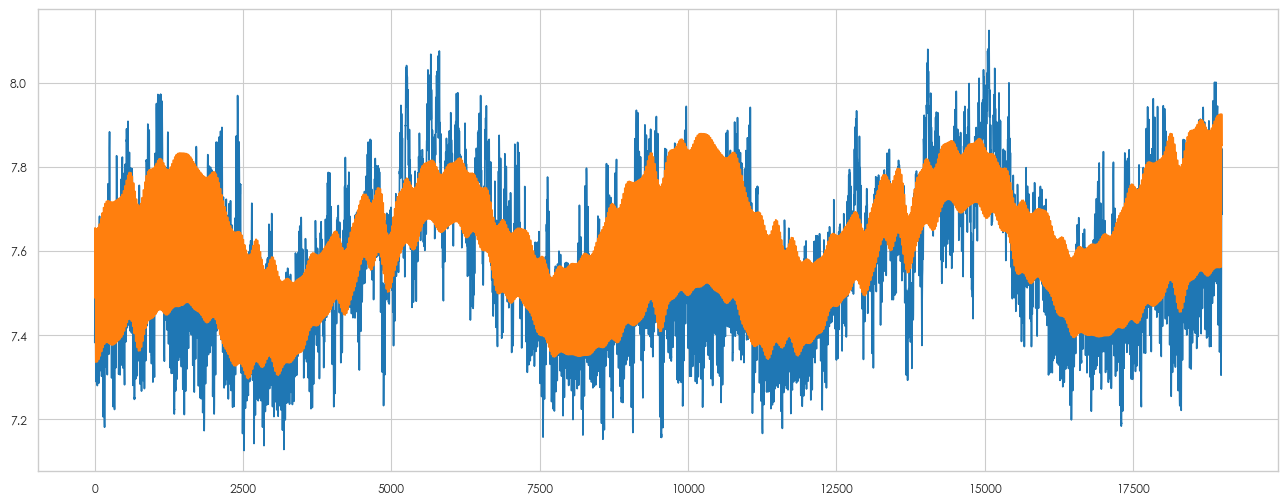

In [17]:
sns.lineplot(y_test)
sns.lineplot(model_baseline.predict(X_test));

In [18]:
resid = np.log(data.values) - model_baseline.predict(data.index)

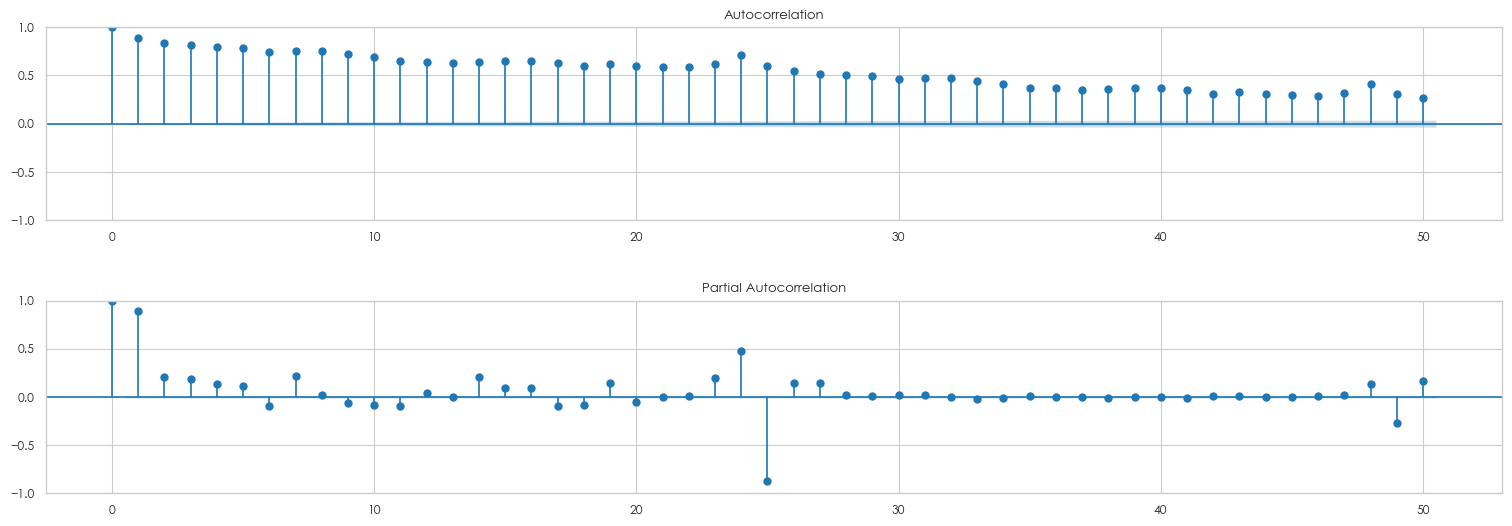

In [19]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=4.0)

plot_acf(resid, ax=ax[0])
plot_pacf(resid, ax=ax[1]);

#### Modeling auto-correlation in residuals

Auto-correlation still exists in the residuals at lag 1 and a seasonal lag of 24.

We will train an S-ARMA model to capture the auto-correlation.

In [20]:
train_resid, test_resid = train_test_split(resid, test_size=0.2, shuffle=False)

In [21]:
model_sarima = ARIMA(train_resid, order=(1,0,1), seasonal_order=(3,0,1,12)).fit() # optimal hyper-parameters obtained after a few trial and error.

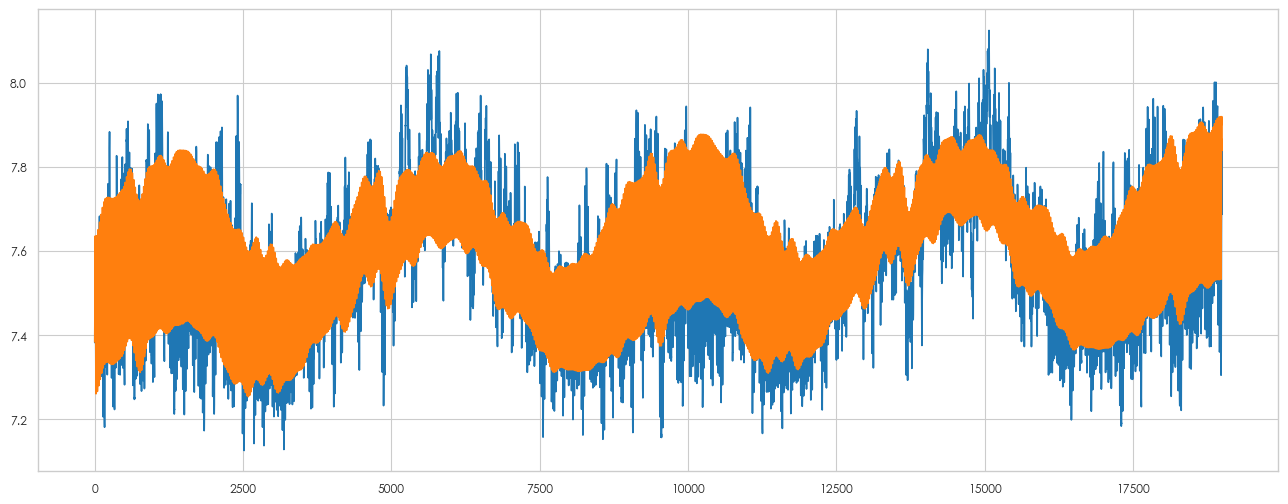

In [22]:
sns.lineplot(y_test)
sns.lineplot(model_sarima.forecast(len(test_resid)) + model_baseline.predict(X_test));

In [23]:
# r2 score on full model

r2_score(y_test, model_sarima.forecast(len(test_resid)) + model_baseline.predict(X_test))

0.5996768037147933

There is a 5% increase in the r<sup>2</sup> score.

Now, let's train both the models on the complete dataset and predict the submission dataset.

In [24]:
submission_data = pd.read_csv("./data/test_WudNWDM.csv", parse_dates=["datetime"])
submission_data.head()

,row_id,datetime
0,94993,2019-01-01 00:00:00
1,94994,2019-01-01 01:00:00
2,94995,2019-01-01 02:00:00
3,94996,2019-01-01 03:00:00
4,94997,2019-01-01 04:00:00


In [25]:
model_baseline_full = pipe_baseline.fit(data.index, data.values)
resid = data.values - model_baseline_full.predict(data.index)

model_sarima_full = ARIMA(resid, order=(1,0,1), seasonal_order=(3,0,1,12)).fit()

In [30]:
pred = model_baseline_full.predict(submission_data["datetime"].values) + model_sarima_full.forecast(len(submission_data))

submission_data["energy"] = pred

submission_data[["row_id", "energy"]].to_csv("./data/energy_consumption_submission.csv", index=False)

In [31]:
submission_data.head()

,row_id,datetime,energy
0,94993,2019-01-01 00:00:00,2358.195293
1,94994,2019-01-01 01:00:00,1863.607874
2,94995,2019-01-01 02:00:00,1863.607874
3,94996,2019-01-01 03:00:00,1863.607874
4,94997,2019-01-01 04:00:00,1863.607874
